In [1]:
import gym
#import pybulletgym
import random
import numpy as np
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
import time
from gym.envs.registration import register
from IPython.display import clear_output
from itertools import count

In [2]:
tf.keras.backend.set_floatx('float64')

In [3]:
env = gym.make('HalfCheetah-v2')
print('observation_space:', env.observation_space.shape)
print('action_space:', env.action_space.shape)

act_limit = env.action_space.high[0]

observation_space: (17,)
action_space: (6,)


In [4]:
print(env.action_space.high, env.action_space.low)

[1. 1. 1. 1. 1. 1.] [-1. -1. -1. -1. -1. -1.]


In [5]:
from collections import deque

class Agent():
    def __init__(self, env):
        self.gamma = 0.97
        
        self.env = env
        state_dim = np.squeeze(env.observation_space.shape)
        action_dim = np.squeeze(env.action_space.shape)
        
        self.state_dim, self.action_dim = state_dim, action_dim
        
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim, action_dim)
        
        self.target_actor = Actor(state_dim, action_dim)
        self.target_critic = Critic(state_dim, action_dim)
        
        self.target_actor.model.set_weights(self.actor.model.get_weights())
        self.target_critic.model.set_weights(self.critic.model.get_weights())
        
        self.memory = deque(maxlen=1000000)
        
    def experience(self, e):
        self.memory.append(e)
        
    def replay(self, size):
        samples = random.sample(self.memory, size)
        states, actions, next_states, rewards, dones = zip(*samples)
        
        states = np.asarray(states).reshape((-1, self.state_dim))
        actions = np.asarray(actions).reshape((-1, self.action_dim))
        next_states = np.asarray(next_states).reshape((-1, self.state_dim))
        rewards = np.asarray(rewards).reshape((-1, 1))
        dones = np.asarray(dones).reshape((-1, 1)).astype(np.float)
        
        states = tf.convert_to_tensor(states)
        actions = tf.convert_to_tensor(actions)
        next_states = tf.convert_to_tensor(next_states)
        rewards = tf.convert_to_tensor(rewards)
        dones = tf.convert_to_tensor(dones)
        
        return states, actions, next_states, rewards, dones
        
    @tf.function
    def train(self, states, actions, next_states, rewards, dones):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor.model(next_states)
            next_values = self.target_critic.model([next_states, target_actions])
            target_values = rewards + self.gamma * next_values * (1 - dones)
            
            values = self.critic.get_value(states, actions)
            #critic_loss = tf.reduce_mean(tf.square(target_values - values))
            critic_loss = tf.compat.v1.losses.huber_loss(
                tf.cast(target_values, tf.float32), 
                tf.cast(values, tf.float32))
        critic_grad = tape.gradient(critic_loss, self.critic.model.trainable_variables)
        self.critic.optimizer.apply_gradients(
            zip(critic_grad, self.critic.model.trainable_variables)
        )
        
        with tf.GradientTape() as tape:
            actions = self.actor.model(states)
            values = self.critic.model([states, actions])
            actor_loss = -tf.reduce_mean(values)
        actor_grad = tape.gradient(actor_loss, self.actor.model.trainable_variables)
        self.actor.optimizer.apply_gradients(
            zip(actor_grad, self.actor.model.trainable_variables)
        )

In [6]:
class Actor():
    def __init__(self, state_dim, action_dim):
        
        last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
        inputs = tf.keras.Input((state_dim,))
        hidden = tf.keras.layers.Dense(128, activation='relu')(inputs)
        #hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = tf.keras.layers.Dense(128, activation='relu')(hidden)
        #hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = tf.keras.layers.Dense(128, activation='relu')(hidden)
        #hidden = tf.keras.layers.BatchNormalization()(hidden)
        outputs = tf.keras.layers.Dense(
            action_dim, activation='tanh', kernel_initializer=last_init
            #action_dim, activation='linear'
        )(hidden)

        outputs = outputs * act_limit
        model = tf.keras.Model(inputs, outputs)
        
        self.model = model
        self.optimizer = tf.keras.optimizers.Adam(lr=0.0003)
        
    def get_policy(self, states):
        policy = self.model(tf.convert_to_tensor(states))
        return policy
        
    def get_action(self, state, noise=True):
        states = np.expand_dims(state, axis=0)
        #print(state.shape)
        action = self.get_policy(states)
        
        if noise:
            action += np.random.normal(0, 0.1*(act_limit-(-act_limit)))
                                       
        #print(action)
        action = np.clip(action, -act_limit, act_limit)
        return action
    
class Critic():
    def __init__(self, state_dim, action_dim):
        state_in = tf.keras.Input((state_dim,))
        action_in = tf.keras.Input((action_dim,))
        
        concat = tf.keras.layers.concatenate([state_in, action_in])
        hidden = tf.keras.layers.Dense(128, activation='relu')(concat)
        #hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = tf.keras.layers.Dense(128, activation='relu')(hidden)
        hidden = tf.keras.layers.Dense(128, activation='relu')(hidden)
        #hidden = tf.keras.layers.BatchNormalization()(hidden)
        output = tf.keras.layers.Dense(1, activation='linear')(hidden)
        
        model = tf.keras.Model([state_in, action_in], output)
        
        self.model = model
        self.optimizer = tf.keras.optimizers.Adam(lr=0.0003)
        
        #model.summary()
        
        #print(concat)
        
    def get_value(self, states, actions):
        states, actions = tf.convert_to_tensor(states), tf.convert_to_tensor(actions)
        value = self.model([states, actions])
        return value
    
agent = Agent(env)


@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


In [7]:
tau = 0.003

def run(agent, num_episodes, render=False):

    history = []
        
    for ep in range(num_episodes):
                
        state = env.reset()
        
        done = False
        ep_reward = 0
        for step in count():
            action = agent.actor.get_action(state)[0]
            next_state, reward, done, _ = env.step(action)
            
            if render:
                env.render()
            
            ep_reward += reward
            
            agent.experience((state, action, next_state, reward, done))
            
            batch_size = 256
            if len(agent.memory) > batch_size:
                states, actions, next_states, rewards, dones = agent.replay(batch_size)
                agent.train(states, actions, next_states, rewards, dones)
                
            update_target(agent.target_actor.model.variables, agent.actor.model.variables, tau)
            update_target(agent.target_critic.model.variables, agent.critic.model.variables, tau)
            
            if done:
                break
                
            state = next_state
                
            #if step == 1: break
        history.append(ep_reward)
        print(f'Episode: {ep}, ep_reward: {ep_reward}, step: {step+1}')
        
    import matplotlib.pyplot as plt
    %matplotlib inline

    avg_span = 50
    def plot(history, title):
        fig1, ax1 = plt.subplots()
        x = range(len(history))
        cumsum = np.cumsum(history)
        avgs = [cumsum[ep]/(ep+1) if ep<avg_span else (cumsum[ep]-cumsum[ep-avg_span])/avg_span for ep in x]
        ax1.plot(x, avgs, label=title)
        ax1.set_title("History")
        ax1.set_xlabel("Episode")
        ax1.set_ylabel("moving average 100")
        ax1.legend()

    plot(history, 'total_reward')

Episode: 0, ep_reward: -278.26070173673736, step: 1000
Episode: 1, ep_reward: 218.33989552586547, step: 1000
Episode: 2, ep_reward: 196.6964263932089, step: 1000
Episode: 3, ep_reward: -264.5608079684604, step: 1000
Episode: 4, ep_reward: -326.3444950440732, step: 1000
Episode: 5, ep_reward: 117.61630394313049, step: 1000
Episode: 6, ep_reward: 717.213232107913, step: 1000
Episode: 7, ep_reward: -54.28247390603055, step: 1000
Episode: 8, ep_reward: -133.39558410807857, step: 1000
Episode: 9, ep_reward: 977.6999733473798, step: 1000
Episode: 10, ep_reward: 976.2987364045484, step: 1000
Episode: 11, ep_reward: 282.1234780894381, step: 1000
Episode: 12, ep_reward: 467.2976432462611, step: 1000
Episode: 13, ep_reward: 930.3349410373173, step: 1000
Episode: 14, ep_reward: 466.9633784992624, step: 1000
Episode: 15, ep_reward: 805.5573170803441, step: 1000
Episode: 16, ep_reward: 977.167700131223, step: 1000
Episode: 17, ep_reward: 185.8700916175983, step: 1000
Episode: 18, ep_reward: -334.97

Episode: 150, ep_reward: 3803.925115840932, step: 1000
Episode: 151, ep_reward: 3842.339326239312, step: 1000
Episode: 152, ep_reward: 3956.280458180338, step: 1000
Episode: 153, ep_reward: 3443.1794318654697, step: 1000
Episode: 154, ep_reward: 3907.616342055208, step: 1000
Episode: 155, ep_reward: 3723.9449475345623, step: 1000
Episode: 156, ep_reward: 3762.544610311667, step: 1000
Episode: 157, ep_reward: 3982.0814434478416, step: 1000
Episode: 158, ep_reward: 3600.012691314348, step: 1000
Episode: 159, ep_reward: 3804.5788243871384, step: 1000
Episode: 160, ep_reward: 3929.257791466921, step: 1000
Episode: 161, ep_reward: 4012.2894666023244, step: 1000
Episode: 162, ep_reward: 3924.6277526285003, step: 1000
Episode: 163, ep_reward: 4008.443043392656, step: 1000
Episode: 164, ep_reward: 3840.0715731238374, step: 1000
Episode: 165, ep_reward: 2183.753842929632, step: 1000
Episode: 166, ep_reward: 3882.3940625117584, step: 1000
Episode: 167, ep_reward: 3900.831337595609, step: 1000
Ep

Episode: 298, ep_reward: 4368.1327356635065, step: 1000
Episode: 299, ep_reward: 4397.109745663375, step: 1000
Episode: 300, ep_reward: 4382.641950753747, step: 1000
Episode: 301, ep_reward: 3113.594982008604, step: 1000
Episode: 302, ep_reward: 1290.7429514794244, step: 1000
Episode: 303, ep_reward: 4352.027464418284, step: 1000
Episode: 304, ep_reward: 3603.1159198558803, step: 1000
Episode: 305, ep_reward: 1480.3102221918523, step: 1000
Episode: 306, ep_reward: 3464.4726791878943, step: 1000
Episode: 307, ep_reward: 4445.291853016135, step: 1000
Episode: 308, ep_reward: 4570.95330184972, step: 1000
Episode: 309, ep_reward: 4532.24843103287, step: 1000
Episode: 310, ep_reward: 4378.234869499737, step: 1000
Episode: 311, ep_reward: 3632.777733855945, step: 1000
Episode: 312, ep_reward: 1318.1674884018992, step: 1000
Episode: 313, ep_reward: 4411.212728403559, step: 1000
Episode: 314, ep_reward: 3638.0503167152124, step: 1000
Episode: 315, ep_reward: 4461.018075036859, step: 1000
Episo

Episode: 447, ep_reward: 4806.6733598955725, step: 1000
Episode: 448, ep_reward: 1269.445531184585, step: 1000
Episode: 449, ep_reward: 5067.841479407399, step: 1000
Episode: 450, ep_reward: 4620.2045509586405, step: 1000
Episode: 451, ep_reward: 4478.253185550828, step: 1000
Episode: 452, ep_reward: 4844.842477494829, step: 1000
Episode: 453, ep_reward: 4705.72343062044, step: 1000
Episode: 454, ep_reward: 4820.10775537631, step: 1000
Episode: 455, ep_reward: 3953.0598825055986, step: 1000
Episode: 456, ep_reward: 2575.7976193579725, step: 1000
Episode: 457, ep_reward: 1637.20780482161, step: 1000
Episode: 458, ep_reward: 4699.266884150288, step: 1000
Episode: 459, ep_reward: 4758.116151064679, step: 1000
Episode: 460, ep_reward: 4683.233215715431, step: 1000
Episode: 461, ep_reward: 1835.2840150306406, step: 1000
Episode: 462, ep_reward: 5017.126991523234, step: 1000
Episode: 463, ep_reward: 2157.1227789444993, step: 1000
Episode: 464, ep_reward: 3603.205520378809, step: 1000
Episode

Episode: 596, ep_reward: 5795.175448156891, step: 1000
Episode: 597, ep_reward: 5835.617177245387, step: 1000
Episode: 598, ep_reward: 5767.803932969678, step: 1000
Episode: 599, ep_reward: 5763.096100160689, step: 1000
Episode: 600, ep_reward: 5975.0861985635565, step: 1000
Episode: 601, ep_reward: 5996.984830674192, step: 1000
Episode: 602, ep_reward: 5836.455746371144, step: 1000
Episode: 603, ep_reward: 5473.736929025169, step: 1000
Episode: 604, ep_reward: 5839.033945912177, step: 1000
Episode: 605, ep_reward: 5709.656549558382, step: 1000
Episode: 606, ep_reward: 5824.636505698626, step: 1000
Episode: 607, ep_reward: 5848.7548892272835, step: 1000
Episode: 608, ep_reward: 6020.787327431304, step: 1000
Episode: 609, ep_reward: 5922.012645297498, step: 1000
Episode: 610, ep_reward: 5819.658336595763, step: 1000
Episode: 611, ep_reward: 5863.464296294294, step: 1000
Episode: 612, ep_reward: 5931.877247267122, step: 1000
Episode: 613, ep_reward: 6170.178285292434, step: 1000
Episode:

Episode: 746, ep_reward: 6875.069295870891, step: 1000
Episode: 747, ep_reward: 7032.17654398082, step: 1000
Episode: 748, ep_reward: 6766.354846056322, step: 1000
Episode: 749, ep_reward: 6796.779280895136, step: 1000
Episode: 750, ep_reward: 6665.270873146107, step: 1000
Episode: 751, ep_reward: 6471.878557033342, step: 1000
Episode: 752, ep_reward: 4624.453180876242, step: 1000
Episode: 753, ep_reward: 7190.372893415339, step: 1000
Episode: 754, ep_reward: 6364.28885094852, step: 1000
Episode: 755, ep_reward: 3233.797758902392, step: 1000
Episode: 756, ep_reward: 7101.826821340717, step: 1000
Episode: 757, ep_reward: 7356.724805818297, step: 1000
Episode: 758, ep_reward: 4652.480033414571, step: 1000
Episode: 759, ep_reward: 4974.603533193469, step: 1000
Episode: 760, ep_reward: 1848.8736104130057, step: 1000
Episode: 761, ep_reward: 2217.777525445999, step: 1000
Episode: 762, ep_reward: 6636.595590314924, step: 1000
Episode: 763, ep_reward: 7048.517060726156, step: 1000
Episode: 76

Episode: 895, ep_reward: 4101.2897257727045, step: 1000
Episode: 896, ep_reward: 7856.119475327216, step: 1000
Episode: 897, ep_reward: 2778.947948390577, step: 1000
Episode: 898, ep_reward: 7527.904487382828, step: 1000
Episode: 899, ep_reward: 2551.8401030117134, step: 1000
Episode: 900, ep_reward: 2608.9844234953016, step: 1000
Episode: 901, ep_reward: 1492.2787070941056, step: 1000
Episode: 902, ep_reward: 7124.86336901496, step: 1000
Episode: 903, ep_reward: 5900.39415808967, step: 1000
Episode: 904, ep_reward: 1650.7184154843635, step: 1000
Episode: 905, ep_reward: 4176.616841234441, step: 1000
Episode: 906, ep_reward: 8083.369431655818, step: 1000
Episode: 907, ep_reward: 7998.1554842027, step: 1000
Episode: 908, ep_reward: 5257.488494500295, step: 1000
Episode: 909, ep_reward: 7336.696231877945, step: 1000
Episode: 910, ep_reward: 6332.379224475117, step: 1000
Episode: 911, ep_reward: 3935.2401833656854, step: 1000
Episode: 912, ep_reward: 5613.851882270569, step: 1000
Episode:

Episode: 1043, ep_reward: 3479.8315574345875, step: 1000
Episode: 1044, ep_reward: 8715.051470571161, step: 1000
Episode: 1045, ep_reward: 6632.377222222539, step: 1000
Episode: 1046, ep_reward: 8968.057470057369, step: 1000
Episode: 1047, ep_reward: 7665.923286986772, step: 1000
Episode: 1048, ep_reward: 7064.426841086352, step: 1000
Episode: 1049, ep_reward: 8651.354205487298, step: 1000
Episode: 1050, ep_reward: 4485.209529457427, step: 1000
Episode: 1051, ep_reward: 8688.645421143205, step: 1000
Episode: 1052, ep_reward: 8694.330820333284, step: 1000
Episode: 1053, ep_reward: 4043.9509756671505, step: 1000
Episode: 1054, ep_reward: 8806.083667590903, step: 1000
Episode: 1055, ep_reward: 8835.457780441951, step: 1000
Episode: 1056, ep_reward: 8405.001076774692, step: 1000
Episode: 1057, ep_reward: 2463.6533000690656, step: 1000
Episode: 1058, ep_reward: 8435.083772621676, step: 1000
Episode: 1059, ep_reward: 8616.450749168273, step: 1000
Episode: 1060, ep_reward: 9080.344045540076, 

Episode: 1189, ep_reward: 5991.490600404899, step: 1000
Episode: 1190, ep_reward: 1490.2927148322278, step: 1000
Episode: 1191, ep_reward: 8842.329245467583, step: 1000
Episode: 1192, ep_reward: 8902.796637921705, step: 1000
Episode: 1193, ep_reward: 1669.4392364092462, step: 1000
Episode: 1194, ep_reward: 9166.942036174361, step: 1000
Episode: 1195, ep_reward: 9174.663368739872, step: 1000
Episode: 1196, ep_reward: 5524.943668083577, step: 1000
Episode: 1197, ep_reward: 8923.524751367186, step: 1000
Episode: 1198, ep_reward: 8497.422191163361, step: 1000
Episode: 1199, ep_reward: 8828.610217750183, step: 1000
Episode: 1200, ep_reward: 8392.520933247482, step: 1000
Episode: 1201, ep_reward: 9030.43106592627, step: 1000
Episode: 1202, ep_reward: 4933.588115848154, step: 1000
Episode: 1203, ep_reward: 9756.87794933422, step: 1000
Episode: 1204, ep_reward: 5884.627508853753, step: 1000
Episode: 1205, ep_reward: 7582.776333850505, step: 1000
Episode: 1206, ep_reward: 9113.306458013938, ste

Episode: 1336, ep_reward: 9152.571022884378, step: 1000
Episode: 1337, ep_reward: 5070.997342654355, step: 1000
Episode: 1338, ep_reward: 5700.923736776912, step: 1000
Episode: 1339, ep_reward: 2658.9442485875365, step: 1000
Episode: 1340, ep_reward: 9033.6663629712, step: 1000
Episode: 1341, ep_reward: 8881.923480643869, step: 1000
Episode: 1342, ep_reward: 5689.067346217752, step: 1000
Episode: 1343, ep_reward: 9578.473248381062, step: 1000
Episode: 1344, ep_reward: 9136.991400494062, step: 1000
Episode: 1345, ep_reward: 4394.1535604894925, step: 1000
Episode: 1346, ep_reward: 3885.1757210855917, step: 1000
Episode: 1347, ep_reward: 9558.015024831891, step: 1000
Episode: 1348, ep_reward: 9377.218442198791, step: 1000
Episode: 1349, ep_reward: 3984.5688587471413, step: 1000
Episode: 1350, ep_reward: 9071.223737650593, step: 1000
Episode: 1351, ep_reward: 4104.900313362717, step: 1000
Episode: 1352, ep_reward: 7784.395110356264, step: 1000
Episode: 1353, ep_reward: 8998.163779940605, s

Episode: 1483, ep_reward: 6507.4331228111505, step: 1000
Episode: 1484, ep_reward: 7367.931003818358, step: 1000
Episode: 1485, ep_reward: 1562.3733194746326, step: 1000
Episode: 1486, ep_reward: 3982.9796576125195, step: 1000
Episode: 1487, ep_reward: 3327.298828418245, step: 1000
Episode: 1488, ep_reward: 1723.1159504720201, step: 1000
Episode: 1489, ep_reward: 9842.759626527446, step: 1000
Episode: 1490, ep_reward: 4567.018314187291, step: 1000
Episode: 1491, ep_reward: 10080.755288336573, step: 1000
Episode: 1492, ep_reward: 9845.694626229597, step: 1000
Episode: 1493, ep_reward: 4242.742976657591, step: 1000
Episode: 1494, ep_reward: 9476.807778036857, step: 1000
Episode: 1495, ep_reward: 9752.778636182911, step: 1000
Episode: 1496, ep_reward: 6505.948832374958, step: 1000
Episode: 1497, ep_reward: 5437.091461807327, step: 1000
Episode: 1498, ep_reward: 9756.005463006768, step: 1000
Episode: 1499, ep_reward: 9275.94955051738, step: 1000
Episode: 1500, ep_reward: 9289.189559290118,

Episode: 1629, ep_reward: 5830.679216643211, step: 1000
Episode: 1630, ep_reward: 9604.157556134713, step: 1000
Episode: 1631, ep_reward: 4444.76823670578, step: 1000
Episode: 1632, ep_reward: 8522.004212901184, step: 1000
Episode: 1633, ep_reward: 10150.762967940651, step: 1000
Episode: 1634, ep_reward: 3626.9667099602325, step: 1000
Episode: 1635, ep_reward: 9614.177876433287, step: 1000
Episode: 1636, ep_reward: 5694.728398795788, step: 1000
Episode: 1637, ep_reward: 5059.061711711294, step: 1000
Episode: 1638, ep_reward: 2449.9882483062074, step: 1000
Episode: 1639, ep_reward: 10675.896397011455, step: 1000
Episode: 1640, ep_reward: 4427.818924951105, step: 1000
Episode: 1641, ep_reward: 10153.078495194923, step: 1000
Episode: 1642, ep_reward: 10454.372353158287, step: 1000
Episode: 1643, ep_reward: 3869.390475610323, step: 1000
Episode: 1644, ep_reward: 6484.671768052447, step: 1000
Episode: 1645, ep_reward: 6043.664813209789, step: 1000
Episode: 1646, ep_reward: 7010.914249517104

Episode: 1775, ep_reward: 5804.286799130444, step: 1000
Episode: 1776, ep_reward: 4382.481180028368, step: 1000
Episode: 1777, ep_reward: 2722.686287592839, step: 1000
Episode: 1778, ep_reward: 2545.2687082196885, step: 1000
Episode: 1779, ep_reward: 2719.39553732645, step: 1000
Episode: 1780, ep_reward: 10224.084339279063, step: 1000
Episode: 1781, ep_reward: 3652.634242162002, step: 1000
Episode: 1782, ep_reward: 9519.58624335976, step: 1000
Episode: 1783, ep_reward: 4894.0893138974025, step: 1000
Episode: 1784, ep_reward: 3251.543420502662, step: 1000
Episode: 1785, ep_reward: 10329.56969833188, step: 1000
Episode: 1786, ep_reward: 2986.821821987961, step: 1000
Episode: 1787, ep_reward: 4423.118078655471, step: 1000
Episode: 1788, ep_reward: 9982.013766407483, step: 1000
Episode: 1789, ep_reward: 6186.5174017789095, step: 1000
Episode: 1790, ep_reward: 10497.383921739513, step: 1000
Episode: 1791, ep_reward: 9808.360714419856, step: 1000
Episode: 1792, ep_reward: 10368.20496804074, 

Episode: 1921, ep_reward: 1626.0733729550154, step: 1000
Episode: 1922, ep_reward: 9907.614871686443, step: 1000
Episode: 1923, ep_reward: 10545.665813828877, step: 1000
Episode: 1924, ep_reward: 9905.25257601855, step: 1000
Episode: 1925, ep_reward: 7400.823808863451, step: 1000
Episode: 1926, ep_reward: 4098.819572648105, step: 1000
Episode: 1927, ep_reward: 9323.818818499009, step: 1000
Episode: 1928, ep_reward: 4810.3437310101945, step: 1000
Episode: 1929, ep_reward: 10297.767890112173, step: 1000
Episode: 1930, ep_reward: 2408.777763058724, step: 1000
Episode: 1931, ep_reward: 8421.908903469359, step: 1000
Episode: 1932, ep_reward: 8556.959812218383, step: 1000
Episode: 1933, ep_reward: 9347.156105234644, step: 1000
Episode: 1934, ep_reward: 2889.905839763687, step: 1000
Episode: 1935, ep_reward: 5452.909578496866, step: 1000
Episode: 1936, ep_reward: 8017.231220209647, step: 1000
Episode: 1937, ep_reward: 3592.041273369349, step: 1000
Episode: 1938, ep_reward: 10562.281826841523,

Episode: 2067, ep_reward: 2212.1232050482963, step: 1000
Episode: 2068, ep_reward: 2794.71942375419, step: 1000
Episode: 2069, ep_reward: 11156.888329693107, step: 1000
Episode: 2070, ep_reward: 10479.696440205014, step: 1000
Episode: 2071, ep_reward: 10014.445668082015, step: 1000
Episode: 2072, ep_reward: 7568.1144145806065, step: 1000
Episode: 2073, ep_reward: 5407.858357946635, step: 1000
Episode: 2074, ep_reward: 10052.6079876623, step: 1000
Episode: 2075, ep_reward: 8006.615828428674, step: 1000
Episode: 2076, ep_reward: 10716.882171408428, step: 1000
Episode: 2077, ep_reward: 10207.653026124137, step: 1000
Episode: 2078, ep_reward: 9934.759341575038, step: 1000
Episode: 2079, ep_reward: 10194.76566787086, step: 1000
Episode: 2080, ep_reward: 4662.571390584458, step: 1000
Episode: 2081, ep_reward: 10230.037310633976, step: 1000
Episode: 2082, ep_reward: 9903.644401397009, step: 1000
Episode: 2083, ep_reward: 7999.041883322639, step: 1000
Episode: 2084, ep_reward: 4041.56456246299

Episode: 2213, ep_reward: 10213.588988941385, step: 1000
Episode: 2214, ep_reward: 10949.060835881255, step: 1000
Episode: 2215, ep_reward: 2447.0261022239374, step: 1000
Episode: 2216, ep_reward: 8582.21228184552, step: 1000
Episode: 2217, ep_reward: 2334.064718067731, step: 1000
Episode: 2218, ep_reward: 10766.414245631047, step: 1000
Episode: 2219, ep_reward: 11294.719813423579, step: 1000
Episode: 2220, ep_reward: 1476.3234616971513, step: 1000
Episode: 2221, ep_reward: 10798.562341521892, step: 1000
Episode: 2222, ep_reward: 5112.970098458806, step: 1000
Episode: 2223, ep_reward: 10881.353676571665, step: 1000
Episode: 2224, ep_reward: 10352.15333926335, step: 1000
Episode: 2225, ep_reward: 11051.110299174981, step: 1000
Episode: 2226, ep_reward: 10855.108001689974, step: 1000
Episode: 2227, ep_reward: 3565.5465772273083, step: 1000
Episode: 2228, ep_reward: 3707.714818196621, step: 1000
Episode: 2229, ep_reward: 10900.078157862832, step: 1000
Episode: 2230, ep_reward: 10833.77135

Episode: 2359, ep_reward: 10553.761494685832, step: 1000
Episode: 2360, ep_reward: 8328.250421878376, step: 1000
Episode: 2361, ep_reward: 4450.677049455806, step: 1000
Episode: 2362, ep_reward: 8737.114551125986, step: 1000
Episode: 2363, ep_reward: 11288.44787528413, step: 1000
Episode: 2364, ep_reward: 4681.651712613412, step: 1000
Episode: 2365, ep_reward: 11065.071828255293, step: 1000
Episode: 2366, ep_reward: 5466.8783117721005, step: 1000
Episode: 2367, ep_reward: 10503.751889811358, step: 1000
Episode: 2368, ep_reward: 5455.088521707387, step: 1000
Episode: 2369, ep_reward: 3232.2031632622225, step: 1000
Episode: 2370, ep_reward: 3976.968522985474, step: 1000
Episode: 2371, ep_reward: 5925.87782783345, step: 1000
Episode: 2372, ep_reward: 11327.08850643027, step: 1000
Episode: 2373, ep_reward: 10216.907369562461, step: 1000
Episode: 2374, ep_reward: 10463.457534356028, step: 1000
Episode: 2375, ep_reward: 10171.498778141997, step: 1000
Episode: 2376, ep_reward: 1972.9634590653

Episode: 2505, ep_reward: 10195.45757103061, step: 1000
Episode: 2506, ep_reward: 10534.633486812309, step: 1000
Episode: 2507, ep_reward: 3628.0552637975675, step: 1000
Episode: 2508, ep_reward: 5090.678775246579, step: 1000
Episode: 2509, ep_reward: 8651.127900913705, step: 1000
Episode: 2510, ep_reward: 10924.064309518639, step: 1000
Episode: 2511, ep_reward: 10708.32254091629, step: 1000
Episode: 2512, ep_reward: 9161.178197490455, step: 1000
Episode: 2513, ep_reward: 2296.923293437449, step: 1000
Episode: 2514, ep_reward: 10538.385061836894, step: 1000
Episode: 2515, ep_reward: 10800.310815806466, step: 1000
Episode: 2516, ep_reward: 11264.389589097274, step: 1000
Episode: 2517, ep_reward: 8955.071697297188, step: 1000
Episode: 2518, ep_reward: 9138.376676390373, step: 1000
Episode: 2519, ep_reward: 10419.08992318565, step: 1000
Episode: 2520, ep_reward: 9612.894964833711, step: 1000
Episode: 2521, ep_reward: 2914.6961257152634, step: 1000
Episode: 2522, ep_reward: 10168.748609737

Episode: 2651, ep_reward: 5760.84805842991, step: 1000
Episode: 2652, ep_reward: 7905.048565731284, step: 1000
Episode: 2653, ep_reward: 11148.059218585131, step: 1000
Episode: 2654, ep_reward: 4384.267959706131, step: 1000
Episode: 2655, ep_reward: 3533.9187637208533, step: 1000
Episode: 2656, ep_reward: 9873.666376073561, step: 1000
Episode: 2657, ep_reward: 10234.560101018289, step: 1000
Episode: 2658, ep_reward: 8074.162227322381, step: 1000
Episode: 2659, ep_reward: 3741.2492268379187, step: 1000
Episode: 2660, ep_reward: 10725.736668134088, step: 1000
Episode: 2661, ep_reward: 10193.36669862151, step: 1000
Episode: 2662, ep_reward: 10174.903041454467, step: 1000
Episode: 2663, ep_reward: 3540.494793502616, step: 1000
Episode: 2664, ep_reward: 10665.166263832169, step: 1000
Episode: 2665, ep_reward: 10248.48143999481, step: 1000
Episode: 2666, ep_reward: 4943.588558137794, step: 1000
Episode: 2667, ep_reward: 10291.036822180615, step: 1000
Episode: 2668, ep_reward: 10966.476451421

Episode: 2797, ep_reward: 10657.854964191949, step: 1000
Episode: 2798, ep_reward: 11430.360056994907, step: 1000
Episode: 2799, ep_reward: 8761.086258137384, step: 1000
Episode: 2800, ep_reward: 11165.551160258101, step: 1000
Episode: 2801, ep_reward: 7894.758599253978, step: 1000
Episode: 2802, ep_reward: 8335.90856450828, step: 1000
Episode: 2803, ep_reward: 4747.299472197023, step: 1000
Episode: 2804, ep_reward: 11278.66172946163, step: 1000
Episode: 2805, ep_reward: 6367.808200910715, step: 1000
Episode: 2806, ep_reward: 3912.149899679685, step: 1000
Episode: 2807, ep_reward: 9325.356731391179, step: 1000
Episode: 2808, ep_reward: 10544.05124144855, step: 1000
Episode: 2809, ep_reward: 9247.239437657525, step: 1000
Episode: 2810, ep_reward: 10937.933176013064, step: 1000
Episode: 2811, ep_reward: 3758.062729723519, step: 1000
Episode: 2812, ep_reward: 11525.668257481662, step: 1000
Episode: 2813, ep_reward: 5003.205716232269, step: 1000
Episode: 2814, ep_reward: 5075.136029362288,

Episode: 2943, ep_reward: 10912.739400119312, step: 1000
Episode: 2944, ep_reward: 10901.35369684186, step: 1000
Episode: 2945, ep_reward: 10341.122173931342, step: 1000
Episode: 2946, ep_reward: 9996.083802527624, step: 1000
Episode: 2947, ep_reward: 2127.9198994067733, step: 1000
Episode: 2948, ep_reward: 10989.114659255112, step: 1000
Episode: 2949, ep_reward: 2130.278816259207, step: 1000
Episode: 2950, ep_reward: 10980.252168080055, step: 1000
Episode: 2951, ep_reward: 10951.123847022436, step: 1000
Episode: 2952, ep_reward: 10816.153629328497, step: 1000
Episode: 2953, ep_reward: 11507.456984765427, step: 1000
Episode: 2954, ep_reward: 4752.014773748955, step: 1000
Episode: 2955, ep_reward: 11437.560468434927, step: 1000
Episode: 2956, ep_reward: 11070.648663430115, step: 1000
Episode: 2957, ep_reward: 4380.838491817447, step: 1000
Episode: 2958, ep_reward: 6973.104950037295, step: 1000
Episode: 2959, ep_reward: 11665.217787217436, step: 1000
Episode: 2960, ep_reward: 6495.112680

Episode: 3089, ep_reward: 6063.468090310622, step: 1000
Episode: 3090, ep_reward: 11509.274707772944, step: 1000
Episode: 3091, ep_reward: 4243.332806306, step: 1000
Episode: 3092, ep_reward: 6737.0720017830245, step: 1000
Episode: 3093, ep_reward: 11181.287641679846, step: 1000
Episode: 3094, ep_reward: 638.9133710644929, step: 1000
Episode: 3095, ep_reward: 8559.955259041059, step: 1000
Episode: 3096, ep_reward: 2526.3273528614327, step: 1000
Episode: 3097, ep_reward: 11344.213142003058, step: 1000
Episode: 3098, ep_reward: 11151.35836900411, step: 1000
Episode: 3099, ep_reward: 11091.24737033272, step: 1000
Episode: 3100, ep_reward: 1628.4008142804269, step: 1000
Episode: 3101, ep_reward: 11425.43309381575, step: 1000
Episode: 3102, ep_reward: 2690.3068097948117, step: 1000
Episode: 3103, ep_reward: 11021.953098651267, step: 1000
Episode: 3104, ep_reward: 8903.690672968189, step: 1000
Episode: 3105, ep_reward: 5768.2785775572875, step: 1000
Episode: 3106, ep_reward: 1027.74980148795

Episode: 3234, ep_reward: 11638.825488393151, step: 1000
Episode: 3235, ep_reward: 11666.86897951859, step: 1000
Episode: 3236, ep_reward: 9098.374718589406, step: 1000
Episode: 3237, ep_reward: 10661.583542207336, step: 1000
Episode: 3238, ep_reward: 11607.362030209126, step: 1000
Episode: 3239, ep_reward: 4900.921950654489, step: 1000
Episode: 3240, ep_reward: 11808.732366796952, step: 1000
Episode: 3241, ep_reward: 11540.346697488798, step: 1000
Episode: 3242, ep_reward: 4071.915469755808, step: 1000
Episode: 3243, ep_reward: 10870.048917461849, step: 1000
Episode: 3244, ep_reward: 11796.769417660396, step: 1000
Episode: 3245, ep_reward: 7849.586266722246, step: 1000
Episode: 3246, ep_reward: 10175.918070380318, step: 1000
Episode: 3247, ep_reward: 10884.715645210335, step: 1000
Episode: 3248, ep_reward: 8333.029280268578, step: 1000
Episode: 3249, ep_reward: 12345.203248256155, step: 1000
Episode: 3250, ep_reward: 10389.949029838981, step: 1000
Episode: 3251, ep_reward: 3021.435041

Episode: 3379, ep_reward: 11261.554221348377, step: 1000
Episode: 3380, ep_reward: 10648.55664838475, step: 1000
Episode: 3381, ep_reward: 5212.663057850079, step: 1000
Episode: 3382, ep_reward: 11076.111215578749, step: 1000
Episode: 3383, ep_reward: 11276.745888265688, step: 1000
Episode: 3384, ep_reward: 11851.906797654294, step: 1000
Episode: 3385, ep_reward: 11952.011934148282, step: 1000
Episode: 3386, ep_reward: 12059.900130904407, step: 1000
Episode: 3387, ep_reward: 11722.51915071783, step: 1000
Episode: 3388, ep_reward: 11475.577480932336, step: 1000
Episode: 3389, ep_reward: 3734.155675558246, step: 1000
Episode: 3390, ep_reward: 4298.704642226032, step: 1000
Episode: 3391, ep_reward: 5904.182380818494, step: 1000
Episode: 3392, ep_reward: 10926.101149203347, step: 1000
Episode: 3393, ep_reward: 11576.87127072134, step: 1000
Episode: 3394, ep_reward: 7467.527178211019, step: 1000
Episode: 3395, ep_reward: 1755.7440604183735, step: 1000
Episode: 3396, ep_reward: 3566.32661545

Episode: 3524, ep_reward: 11683.508840851844, step: 1000
Episode: 3525, ep_reward: 11520.47757162646, step: 1000
Episode: 3526, ep_reward: 9809.114630052369, step: 1000
Episode: 3527, ep_reward: 1892.884783935224, step: 1000
Episode: 3528, ep_reward: 2963.111977339767, step: 1000
Episode: 3529, ep_reward: 11962.721382356402, step: 1000
Episode: 3530, ep_reward: 12021.810368081384, step: 1000
Episode: 3531, ep_reward: 6959.150071866778, step: 1000
Episode: 3532, ep_reward: 11813.90825660181, step: 1000
Episode: 3533, ep_reward: 11393.597655650337, step: 1000
Episode: 3534, ep_reward: 6284.304026781418, step: 1000
Episode: 3535, ep_reward: 9663.39212277521, step: 1000
Episode: 3536, ep_reward: 11902.051581611951, step: 1000
Episode: 3537, ep_reward: 11218.296024109492, step: 1000
Episode: 3538, ep_reward: 9564.573338870068, step: 1000
Episode: 3539, ep_reward: 11399.695649529489, step: 1000
Episode: 3540, ep_reward: 10421.921574781234, step: 1000
Episode: 3541, ep_reward: 11309.302927248

Episode: 3669, ep_reward: 11726.343732021813, step: 1000
Episode: 3670, ep_reward: 4505.464892779392, step: 1000
Episode: 3671, ep_reward: 5528.120373983127, step: 1000
Episode: 3672, ep_reward: 2345.4273781477946, step: 1000
Episode: 3673, ep_reward: 10400.438772998375, step: 1000
Episode: 3674, ep_reward: 1166.2831476303124, step: 1000
Episode: 3675, ep_reward: 11573.177613498709, step: 1000
Episode: 3676, ep_reward: 12344.205973401802, step: 1000
Episode: 3677, ep_reward: 5465.019923458965, step: 1000
Episode: 3678, ep_reward: 11483.236081926756, step: 1000
Episode: 3679, ep_reward: 12433.33436435612, step: 1000
Episode: 3680, ep_reward: 9720.475028336403, step: 1000
Episode: 3681, ep_reward: 9496.351002599, step: 1000
Episode: 3682, ep_reward: 11911.707556314259, step: 1000
Episode: 3683, ep_reward: 6949.605272327412, step: 1000
Episode: 3684, ep_reward: 2538.5459229331427, step: 1000
Episode: 3685, ep_reward: 6480.707967049268, step: 1000
Episode: 3686, ep_reward: 11588.3277941006

Episode: 3814, ep_reward: 5400.042132951944, step: 1000
Episode: 3815, ep_reward: 2909.6772917109865, step: 1000
Episode: 3816, ep_reward: 11830.675227829159, step: 1000
Episode: 3817, ep_reward: 11327.900609187807, step: 1000
Episode: 3818, ep_reward: 12512.28869858572, step: 1000
Episode: 3819, ep_reward: 12093.860138119717, step: 1000
Episode: 3820, ep_reward: 12185.459416252424, step: 1000
Episode: 3821, ep_reward: 12089.386245206597, step: 1000
Episode: 3822, ep_reward: 12086.059044139703, step: 1000
Episode: 3823, ep_reward: 8766.345810764424, step: 1000
Episode: 3824, ep_reward: 11683.765881040068, step: 1000
Episode: 3825, ep_reward: 11794.344838748064, step: 1000
Episode: 3826, ep_reward: 11549.058981304186, step: 1000
Episode: 3827, ep_reward: 11842.668073260598, step: 1000
Episode: 3828, ep_reward: 11354.138278264174, step: 1000
Episode: 3829, ep_reward: 12344.489399947659, step: 1000
Episode: 3830, ep_reward: 5065.495813193047, step: 1000
Episode: 3831, ep_reward: 2468.6048

Episode: 3959, ep_reward: 4957.353338704324, step: 1000
Episode: 3960, ep_reward: 12194.091610355812, step: 1000
Episode: 3961, ep_reward: 7592.035289081059, step: 1000
Episode: 3962, ep_reward: 2759.7636103242608, step: 1000
Episode: 3963, ep_reward: 11981.546838920507, step: 1000
Episode: 3964, ep_reward: 11177.212884958932, step: 1000
Episode: 3965, ep_reward: 9320.485192480734, step: 1000
Episode: 3966, ep_reward: 12058.871386594223, step: 1000
Episode: 3967, ep_reward: 1346.9031175332284, step: 1000
Episode: 3968, ep_reward: 11875.145381030277, step: 1000
Episode: 3969, ep_reward: 11965.596163183678, step: 1000
Episode: 3970, ep_reward: 12173.118079889176, step: 1000
Episode: 3971, ep_reward: 8510.824693145267, step: 1000
Episode: 3972, ep_reward: 12018.444955890081, step: 1000
Episode: 3973, ep_reward: 11109.326705654777, step: 1000
Episode: 3974, ep_reward: 854.3454738629089, step: 1000
Episode: 3975, ep_reward: 11765.738655033572, step: 1000
Episode: 3976, ep_reward: 7943.08168

Episode: 4104, ep_reward: 12264.207157660934, step: 1000
Episode: 4105, ep_reward: 11464.438047107957, step: 1000
Episode: 4106, ep_reward: 12041.186386230002, step: 1000
Episode: 4107, ep_reward: 7763.5148741242065, step: 1000
Episode: 4108, ep_reward: 9123.470542760093, step: 1000
Episode: 4109, ep_reward: 5266.035209068092, step: 1000
Episode: 4110, ep_reward: 4607.941761223789, step: 1000
Episode: 4111, ep_reward: 12090.718176853909, step: 1000
Episode: 4112, ep_reward: 3290.8341171982047, step: 1000
Episode: 4113, ep_reward: 12766.220157258129, step: 1000
Episode: 4114, ep_reward: 4455.134111388237, step: 1000
Episode: 4115, ep_reward: 10931.890282265798, step: 1000
Episode: 4116, ep_reward: 12338.31960824827, step: 1000
Episode: 4117, ep_reward: 10389.95674326671, step: 1000
Episode: 4118, ep_reward: 2408.5204078998295, step: 1000
Episode: 4119, ep_reward: 12131.793947226364, step: 1000
Episode: 4120, ep_reward: 1717.1546378860664, step: 1000
Episode: 4121, ep_reward: 11881.13014

Episode: 4249, ep_reward: 12467.427926412569, step: 1000
Episode: 4250, ep_reward: 1817.300146938099, step: 1000
Episode: 4251, ep_reward: 11564.10133615203, step: 1000
Episode: 4252, ep_reward: 12053.53706892622, step: 1000
Episode: 4253, ep_reward: 12033.771791737561, step: 1000
Episode: 4254, ep_reward: 10589.952320106126, step: 1000
Episode: 4255, ep_reward: 12091.20113505968, step: 1000
Episode: 4256, ep_reward: 1949.209792765573, step: 1000
Episode: 4257, ep_reward: 11594.436948415154, step: 1000
Episode: 4258, ep_reward: 12331.398845949132, step: 1000
Episode: 4259, ep_reward: 11353.58050759798, step: 1000
Episode: 4260, ep_reward: 4659.325564553261, step: 1000
Episode: 4261, ep_reward: 11575.551494127847, step: 1000
Episode: 4262, ep_reward: 8793.537266002266, step: 1000
Episode: 4263, ep_reward: 2965.6240840626174, step: 1000
Episode: 4264, ep_reward: 12140.337054766154, step: 1000
Episode: 4265, ep_reward: 12186.589661046151, step: 1000
Episode: 4266, ep_reward: 11409.5479559

Episode: 4394, ep_reward: 12104.464154857704, step: 1000
Episode: 4395, ep_reward: 11523.941503496353, step: 1000
Episode: 4396, ep_reward: 10764.900228645203, step: 1000
Episode: 4397, ep_reward: 7986.1720555697575, step: 1000
Episode: 4398, ep_reward: 12013.171977633885, step: 1000
Episode: 4399, ep_reward: 12228.416049866491, step: 1000
Episode: 4400, ep_reward: 11389.229887556157, step: 1000
Episode: 4401, ep_reward: 12243.344906748647, step: 1000
Episode: 4402, ep_reward: 12404.019603516148, step: 1000
Episode: 4403, ep_reward: 12218.49621610329, step: 1000
Episode: 4404, ep_reward: 6993.098007077601, step: 1000
Episode: 4405, ep_reward: 11444.167618368774, step: 1000
Episode: 4406, ep_reward: 8054.557799008278, step: 1000
Episode: 4407, ep_reward: 8209.628187386239, step: 1000
Episode: 4408, ep_reward: 3413.241784620617, step: 1000
Episode: 4409, ep_reward: 2296.6837167213853, step: 1000
Episode: 4410, ep_reward: 11811.461599849672, step: 1000
Episode: 4411, ep_reward: 11766.2169

Episode: 4539, ep_reward: 4713.54693589361, step: 1000
Episode: 4540, ep_reward: 12419.718906851951, step: 1000
Episode: 4541, ep_reward: 9039.061280954682, step: 1000
Episode: 4542, ep_reward: 2487.210921642555, step: 1000
Episode: 4543, ep_reward: 6849.7771106857535, step: 1000
Episode: 4544, ep_reward: 12485.547922545931, step: 1000
Episode: 4545, ep_reward: 12519.536164341236, step: 1000
Episode: 4546, ep_reward: 8963.668514233517, step: 1000
Episode: 4547, ep_reward: 10316.97019079794, step: 1000
Episode: 4548, ep_reward: 12199.351499145072, step: 1000
Episode: 4549, ep_reward: 12620.73532578642, step: 1000
Episode: 4550, ep_reward: 12433.806168358191, step: 1000
Episode: 4551, ep_reward: 11838.796579260828, step: 1000
Episode: 4552, ep_reward: 4995.142032052011, step: 1000
Episode: 4553, ep_reward: 12761.177575866493, step: 1000
Episode: 4554, ep_reward: 7046.355542460067, step: 1000
Episode: 4555, ep_reward: 12286.379021474571, step: 1000
Episode: 4556, ep_reward: 8544.872486265

Episode: 4684, ep_reward: 10215.855260076252, step: 1000
Episode: 4685, ep_reward: 11467.28495405149, step: 1000
Episode: 4686, ep_reward: 11049.479630652258, step: 1000
Episode: 4687, ep_reward: 3432.6258606532706, step: 1000
Episode: 4688, ep_reward: 8943.692647425563, step: 1000
Episode: 4689, ep_reward: 11488.046119283215, step: 1000
Episode: 4690, ep_reward: 12361.17839622048, step: 1000
Episode: 4691, ep_reward: 12221.729141059352, step: 1000
Episode: 4692, ep_reward: 7479.337681492777, step: 1000
Episode: 4693, ep_reward: 2003.6390768585234, step: 1000
Episode: 4694, ep_reward: 3615.411946491805, step: 1000
Episode: 4695, ep_reward: 12514.241164422876, step: 1000
Episode: 4696, ep_reward: 11521.516314593946, step: 1000
Episode: 4697, ep_reward: 11693.85986971171, step: 1000
Episode: 4698, ep_reward: 11416.159584151874, step: 1000
Episode: 4699, ep_reward: 3971.7734074043246, step: 1000
Episode: 4700, ep_reward: 12319.33754898802, step: 1000
Episode: 4701, ep_reward: 12252.986800

Episode: 4829, ep_reward: 2916.9849752855303, step: 1000
Episode: 4830, ep_reward: 11763.7518324975, step: 1000
Episode: 4831, ep_reward: 11793.448494656308, step: 1000
Episode: 4832, ep_reward: 12025.242514372043, step: 1000
Episode: 4833, ep_reward: 4204.336825786783, step: 1000
Episode: 4834, ep_reward: 11642.529700403331, step: 1000
Episode: 4835, ep_reward: 12490.165885984787, step: 1000
Episode: 4836, ep_reward: 11528.945745444496, step: 1000
Episode: 4837, ep_reward: 11333.419646722845, step: 1000
Episode: 4838, ep_reward: 12473.66763386377, step: 1000
Episode: 4839, ep_reward: 12117.410825288785, step: 1000
Episode: 4840, ep_reward: 12000.48887191189, step: 1000
Episode: 4841, ep_reward: 12402.300367552205, step: 1000
Episode: 4842, ep_reward: 5786.8801597782385, step: 1000
Episode: 4843, ep_reward: 13028.755701943226, step: 1000
Episode: 4844, ep_reward: 1605.8764017433411, step: 1000
Episode: 4845, ep_reward: 8959.007072251614, step: 1000
Episode: 4846, ep_reward: 12914.57746

Episode: 4974, ep_reward: 11706.635028729319, step: 1000
Episode: 4975, ep_reward: 11567.705289013944, step: 1000
Episode: 4976, ep_reward: 7530.802093326467, step: 1000
Episode: 4977, ep_reward: 12596.981301419344, step: 1000
Episode: 4978, ep_reward: 11875.356294420002, step: 1000
Episode: 4979, ep_reward: 8706.384771144569, step: 1000
Episode: 4980, ep_reward: 11233.769113068525, step: 1000
Episode: 4981, ep_reward: 11990.348833343502, step: 1000
Episode: 4982, ep_reward: 11993.850831686026, step: 1000
Episode: 4983, ep_reward: 12322.577152653199, step: 1000
Episode: 4984, ep_reward: 9747.90421841871, step: 1000
Episode: 4985, ep_reward: 12302.38826268818, step: 1000
Episode: 4986, ep_reward: 6795.603593522646, step: 1000
Episode: 4987, ep_reward: 12274.855589931956, step: 1000
Episode: 4988, ep_reward: 12232.272812082056, step: 1000
Episode: 4989, ep_reward: 2649.1252334275136, step: 1000
Episode: 4990, ep_reward: 8268.044890229903, step: 1000
Episode: 4991, ep_reward: 11509.430586

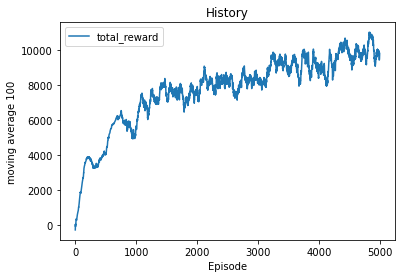

In [8]:
run(agent, 5000, 0)

Creating window glfw
Episode: 0, ep_reward: 7217.89535535626, step: 1000
Episode: 1, ep_reward: 11654.999704043274, step: 1000
Episode: 2, ep_reward: 11415.98378511503, step: 1000
Episode: 3, ep_reward: 4034.213277771998, step: 1000
Episode: 4, ep_reward: 7554.004285731925, step: 1000
Episode: 5, ep_reward: 12921.312194961005, step: 1000
Episode: 6, ep_reward: 1462.8928697317133, step: 1000
Episode: 7, ep_reward: 1686.7297240243404, step: 1000
Episode: 8, ep_reward: 6351.301076117947, step: 1000
Episode: 9, ep_reward: 11110.871361656182, step: 1000


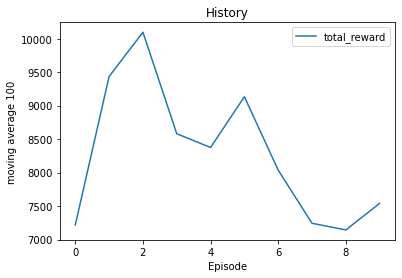

In [10]:
run(agent, 10, 1)

In [12]:
agent.actor.model.save('ddpg_actor.h5')
agent.critic.model.save('ddpg_critic.h5')